# Analysis of FBI Supplemental Homicide Report Data 

In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
from utils import nb_run_from_command


## Data Import

In [2]:
# step backwards if notebook is being run interactively
# or stay put if being run from command line
if nb_run_from_command():
    os.chdir("..")


In [3]:
read_sql = lambda query, con: pd.read_sql(query, con).replace({"": np.NaN, "U": np.NaN})

with sqlite3.connect("input/sqlite__temp.db") as con:
    incidents = read_sql(
        """
        SELECT * FROM data_shrincidents;
        """,
        con,
    )
    offenders = read_sql(
        """
        SELECT * FROM data_shroffenders;
        """,
        con,
    )
    victims = read_sql(
        """
        SELECT * FROM data_shrvictims;
        """,
        con,
    )
    agencies = read_sql(
        """
        SELECT * FROM data_agencies;
        """,
        con,
    )


### Data Preparation

In [4]:
# standard columns used to reduce offender and victim data to one row per incident
GB_COLS = ["incident_id", "ori_code", "year"]


Get a dataframe containing one row per incident and columns indicating which offender information was reported

In [5]:
gb = offenders.groupby(GB_COLS)

join_args = {"how": "left"}

get_offender_info = lambda field: (
    gb[field]
    .apply(lambda vals: any(pd.notna(a) for a in vals))
    .to_frame(f"{field}_reported")
)

offender_info = (
    get_offender_info("offender_age")
    .join(get_offender_info("offender_sex"), **join_args)
    .join(get_offender_info("offender_race"), **join_args)
    .assign(any_offender_info=lambda df: df.any(axis=1))
    .assign(all_offender_info=lambda df: df.all(axis=1))
)

offender_info


,,,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info
incident_id,ori_code,year,,,,,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,True,True,True,True,True
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,False,False,False,False,False
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,True,True,True,True,True
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,False,False,False,False,False
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,True,True,True,True,True
...,...,...,...,...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,True,True,True,True,True
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,False,False,False,False,False
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,False,False,False,False,False


Get a dataframe containing one row per incident with victim demographic data included

In [6]:
victims.victim_race.unique()


array(['B', 'W', 'A', 'I', nan, 'P'], dtype=object)

In [7]:
victims.victim_ethnicity.unique()


array([nan, 'H', 'N'], dtype=object)

In [8]:
victim_info = (
    victims.groupby(GB_COLS)
    .apply(
        lambda group: "hispanic only"
        if all(v == "H" for v in group.victim_ethnicity)
        else "white only"
        if all(v == "W" for v in group.victim_race)
        else "black only"
        if all(v == "B" for v in group.victim_race)
        else "mixed white and black"
        if any(v == "W" for v in group.victim_race)
        and any(v == "B" for v in group.victim_race)
        else "other"
        if all(v in ["A", "I", "P"] for v in group.victim_race)
        else "two or more races" if len(list(set(group.victim_race))) > 1
        else "unknown/no race data"
    )
    .to_frame("race_category")
)

victim_info


,,,race_category
incident_id,ori_code,year,
00001dd6fa45f7ba044bd5d84937be464ce78ac2,PAPEP0000,1995,black only
0000296564272665ccd2925d377e124f3306b01e,INIPD0000,2004,white only
000055d41c8a62052dd426592e8a4a3342bf565d,TX2260100,2020,hispanic only
0000b76d2145d9445d9ff6b65c9ebc4196c89337,GAAPD0000,2007,black only
00010f65a5340264303727655cc554fdfd0da8f2,PA0022800,2001,white only
...,...,...,...
fffe9c57a9b25623ac219260c1b5155087a788e9,TN0750100,2009,black only
fffee86a5a0ce70dab14272b3924c41074fb1c61,GA0630100,2008,white only
fffee88a3e3859d763c7b8f527745155abbb54ac,NY0303000,2011,black only


### Availability of offender demographic information

In [9]:
def get_demo_crosstab(field):
    def to_multiindex(df):
        df.columns = pd.MultiIndex.from_tuples([(field, c) for c in df.columns])
        return df

    return (
        pd.crosstab(
            index=offender_info.index.get_level_values("year"),
            columns=[
                offender_info[field],
            ],
        )
        .assign(pct_reported=lambda df: df[True] / (df[False] + df[True]))
        .pipe(to_multiindex)
    )


(
    get_demo_crosstab("offender_sex_reported")
    .join(get_demo_crosstab("offender_race_reported"))
    .join(get_demo_crosstab("offender_age_reported"))
    .join(get_demo_crosstab("any_offender_info"))
    .join(get_demo_crosstab("all_offender_info"))
)


offender_sex_reported                     offender_race_reported         \
                      False   True pct_reported                  False   True   
row_0                                                                           
1995                   6501  13598     0.676551                   6707  13392   
1996                   5342  11712     0.686760                   5488  11566   
1997                   5117  10812     0.678762                   5263  10666   
1998                   4315   9998     0.698526                   4448   9865   
1999                   3973   9013     0.694055                   4103   8883   
2000                   4093   9127     0.690393                   4200   9020   
2001                   4307   9839     0.695532                   4528   9618   
2002                   4420   9832     0.689868                   4562   9690   
2003                   4643   9778     0.678039                   4772   9649   
2004                   4495   9788     0.685290                   4615   9668   
2005                   4565  10309     0.693089                   4741  10133   
2006                   4637  10439     0.692425                   4768  10308   
2007                   4785  10192     0.680510                   4932  10045   
2008                   4459   9877     0.688965                   4610   9726   
2009                   4091   9767     0.704791                   4211   9647   
2010                   3952   9348     0.702857                   4087   9213   
2011                   3829   9058     0.702879                   3941   8946   
2012                   3978   9090     0.695592                   4086   8982   
2013                   3834   8712     0.694405                   3935   8611   
2014                   3841   8691     0.693505                   3951   8581   
2015                   4459   9385     0.677911                   4591   9253   
2016                   5198  10133     0.660948                   5364   9967   
2017                   4953  10721     0.683999                   5135  10539   
2018                   4422  10502     0.703699                   4594  10330   
2019                   4387  10207     0.699397                   4582  10012   
2020                   5929  12535     0.678889                   6183  12281   

                   offender_age_reported                      \
      pct_reported                 False   True pct_reported   
row_0                                                          
1995      0.666302                  7482  12617     0.627743   
1996      0.678199                  6157  10897     0.638970   
1997      0.669596                  5909  10020     0.629041   
1998      0.689234                  5061   9252     0.646405   
1999      0.684044                  4625   8361     0.643847   
2000      0.682300                  4797   8423     0.637141   
2001      0.679910                  5176   8970     0.634102   
2002      0.679905                  5208   9044     0.634578   
2003      0.669094                  5539   8882     0.615907   
2004      0.676889                  5310   8973     0.628229   
2005      0.681256                  5325   9549     0.641993   
2006      0.683736                  5324   9752     0.646856   
2007      0.670695                  5445   9532     0.636443   
2008      0.678432                  5041   9295     0.648368   
2009      0.696132                  4645   9213     0.664815   
2010      0.692707                  4467   8833     0.664135   
2011      0.694188                  4354   8533     0.662140   
2012      0.687328                  4489   8579     0.656489   
2013      0.686354                  4266   8280     0.659971   
2014      0.684727                  4152   8380     0.668688   
2015      0.668376                  4847   8997     0.649884   
2016      0.650121                  5597   9734     0.634923   
2017      0.672387                  5338  10336     0.65

In [10]:
# single dataframe from which we'll do all analysis
df = (
    incidents.rename(columns={"incident_unique_id": "incident_id"})
    .set_index(GB_COLS)
    .join(offender_info)
    .join(victim_info)
    .reset_index()
)

df


,incident_id,ori_code,year,last_update,homicide,situation,offender_age_reported,offender_sex_reported,offender_race_reported,any_offender_info,all_offender_info,race_category
0,b6589fc6ab0dc82cf12099d1c2d40ab994e8410c,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
1,356a192b7913b04c54574d18c28d46e6395428ab,AK0010100,2020,2021-09-30,A,C,True,True,True,True,True,black only
2,da4b9237bacccdf19c0760cab7aec4a8359010b0,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,white only
3,77de68daecd823babbb58edb1c8e14d7106e83bb,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
4,1b6453892473a467d07372d45eb05abc2031647a,AK0010100,2020,2021-09-30,A,A,True,True,True,True,True,other
...,...,...,...,...,...,...,...,...,...,...,...,...
380983,27f057b7644a9e3a59e579325d91dd5be2b8406a,HI0040000,2005,2005-07-25,A,A,True,True,True,True,True,white only
380984,ae0906ac7c4d9a67e29455bc1f16bac9a05bfcbd,HI0040000,2005,2005-08-17,A,A,True,True,True,True,True,white only
380985,ea8990941c60eb553983d700ad9d41bebd7283e0,HI0050000,2005,2005-08-05,A,B,False,False,False,False,False,black only
380986,1bb31a3533794756fc6cb271898a9ce93526f256,HI0050000,2005,2005-09-22,A,A,True,True,True,True,True,white only


## Analysis

### National

Nationally, the rate of offender demographics reported is substantially lower for homicides with Black victims than it is with white victims. In 2020, less than 60% of cases with only Black victims had offender demographic data present, compared to bout 80% for white victims. Cases with both Black and White victims had offender demographic information bout 72% of the time. 

In [11]:
def get_demo_pcts(df):
    for race in df.columns.get_level_values("race_category"):
        df[(race, "offender_info_reported")] = df[(race, True)] / (
            df[(race, False)] + df[(race, True)]
        )
    return df


national = pd.crosstab(
    index=df.year, columns=[df.race_category, df.any_offender_info]
).pipe(get_demo_pcts)

national.to_csv("output/national.csv")

national


race_category     black only       hispanic only       mixed white and black  \
any_offender_info      False  True         False  True                 False   
year                                                                           
1995                    3487  6249           871  1445                    14   
1996                    2898  5345           689  1301                    14   
1997                    2802  4933           686  1088                     9   
1998                    2317  4374           576  1091                    14   
1999                    2096  3910           566   958                     8   
2000                    2301  3986           562  1016                     4   
2001                    2363  4224           606  1101                     4   
2002                    2526  4262           650  1118                    12   
2003                    2587  4284           747  1131                     7   
2004                    2446  4170           709  1101                    12   
2005                    2546  4537           753  1227                    15   
2006                    2657  4743           730  1266                     7   
2007                    2697  4624           847  1166                     8   
2008                    2531  4241           736  1282                    16   
2009                    2377  4192           668  1219                    16   
2010                    2428  4122           600  1048                    15   
2011                    2388  3996           542   982                    10   
2012                    2530  3996           569   984                    12   
2013                    2456  3810           546   920                    11   
2014                    2460  3747           607  1107                     7   
2015                    2966  4151           691  1128                    11   
2016                    3435  4420           840  1224                    16   
2017                    3190  4623           858  1546                    24   
2018                    2942  4553           712  1565                    12   
2019                    3003  4491           696  1567                    15   
2020                    4018  5810           979  1948                    22   

race_category          other      two or more races       ...  \
any_offender_info True False True             False True  ...   
year                                                      ...   
1995                35   140  360                 4   11  ...   
1996                24   118  314                 2   10  ...   
1997                17   124  311                 5    6  ...   
1998                19    86  239                 3   11  ...   
1999                15    95  256                 6    6  ...   
2000                15    87  251                 6    8  ...   
2001                15   100  261                 6    9  ...   
2002                21    97  275                 5   10  ...   
2003                35   119  286                 2    9  ...   
2004                21    99  267                 9   11  ...   
2005                24   100  294                 4   20  ...   
2006                22   112  277                 7   16  ...   
2007                32    98  242                 3   11  ...   
2008                21    72  240                11   20  ...   
2009                29    90  262                 1   17  ...   
2010                22    62  260                 4   14  ...   
2011                22    61  262                 6   15  ...   
2012                28    64  266                 1   26  ...   
2013                36    57  252                 5   12  ...   
2014                13    70  236                 5   20  ...   
2015                45    69  300                 8   18  ...   
2016                39    80  333                 7   17  ...   
2017                49   108  358                 5   

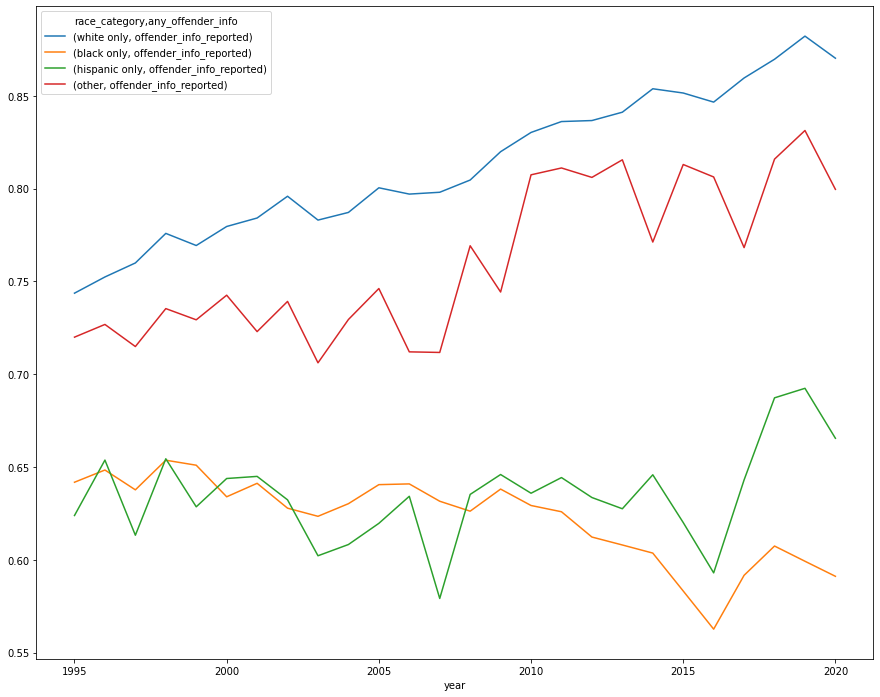

In [12]:
(
    national[
        [
            ("white only", "offender_info_reported"),
            ("black only", "offender_info_reported"),
            ("hispanic only", "offender_info_reported"),
            ("other", "offender_info_reported"),
        ]
    ]
    .plot(figsize=(15, 12))
    .get_figure()
    .savefig("output/black_vs_white_national.svg")
)


### Localized Analysis

In [13]:
df = df.merge(
    agencies,
    how="left",
    left_on=["year", "ori_code"],
    right_on=["data_year", "ori"],
)


#### States

In [14]:
state = pd.crosstab(
    index=[df.year, df.state_abbr],
    columns=[df.race_category, df.any_offender_info],
).pipe(get_demo_pcts)

state.to_csv("output/state.csv")

state


race_category     black only      hispanic only      mixed white and black  \
any_offender_info      False True         False True                 False   
year state_abbr                                                              
1995 AK                    0    7             0    0                     0   
     AL                  114  205             0    0                     0   
     AR                   36  112             1    1                     0   
     AZ                   20   40            52  113                     0   
     CA                  404  519           663  888                     1   
...                      ...  ...           ...  ...                   ...   
2020 VT                    1    2             0    0                     0   
     WA                   18   53             5   29                     0   
     WI                   57  136             8   32                     1   
     WV                    4    8             0    0                     1   
     WY                    0    0             0    2                     0   

race_category          other      two or more races       ...  \
any_offender_info True False True             False True  ...   
year state_abbr                                           ...   
1995 AK              0     8   12                 0    0  ...   
     AL              0     0    4                 0    0  ...   
     AR              0     0    0                 0    0  ...   
     AZ              1     4   13                 0    0  ...   
     CA              4    61  110                 3    2  ...   
...                ...   ...  ...               ...  ...  ...   
2020 VT              0     0    1                 0    0  ...   
     WA              0     3   26                 0    1  ...   
     WI              0     1   12                 0    1  ...   
     WV              0     0    2                 0    2  ...   
     WY              0     0    1                 0    0  ...   

race_category     unknown/no race data white only                  black only  \
any_offender_info                 True      False True offender_info_reported   
year state_abbr                                                                 
1995 AK                              0         12   15               1.000000   
     AL                              3         47   92               0.642633   
     AR                              0         19   91               0.756757   
     AZ                              0         50  161               0.666667   
     CA                             33        229  582               0.562297   
...                                ...        ...  ...                    ...   
2020 VT                              0          1   13               0.666667   
     WA                             15         14  152               0.746479   
     WI                              2          4  139               0.704663   
     WV                              5          4   82               0.666667   
     WY                              0          0   15                    NaN   

race_category              hispanic only  mixed white and black  \
any_offender_info offender_info_reported offender_info_reported   
year state_abbr                                                   
1995 AK                              NaN                    NaN   
     AL                              NaN                    NaN   
     AR                         0.500000                    NaN   
     AZ                         0.684848                    1.0   
     CA                         0.572534                    0.8   
...                                  ...                    ...   
2020 VT                              NaN                    NaN   
     WA                         0.852941                    NaN   
     WI                         0.800000                    0.0   
     WV                              NaN                 

In [15]:
state_2020 = state[state.index.get_level_values("year") == 2020]

state_2020.to_csv("output/state_2020.csv")

state_2020


race_category     black only      hispanic only      mixed white and black  \
any_offender_info      False True         False True                 False   
year state_abbr                                                              
2020 AK                    0    6             0    0                     0   
     AL                    2    7             0    0                     0   
     AR                   46  144             0    5                     0   
     AZ                   29   77            50  107                     0   
     CA                  368  288           485  505                     5   
     CO                    9   63            11   67                     1   
     CT                   33   41            14   26                     0   
     DC                  100   99             3    2                     0   
     DE                   24   35             1    2                     0   
     FL                    0    1             0    0                     0   
     FS                    0    1             0    0                     0   
     GA                   89  329             3   20                     1   
     HI                    0    3             1    0                     0   
     IA                   13   38             1    3                     1   
     ID                    0    0             0    6                     0   
     IL                  500  276            83   57                     0   
     IN                  148  167            15   16                     1   
     KS                    6   22             2   12                     0   
     KY                   77   71             3    6                     1   
     LA                  245  320             2    3                     1   
     MA                   33   32            13   31                     0   
     MD                  199  203             6   20                     0   
     ME                    2    2             0    0                     0   
     MI                  213  327             1    5                     0   
     MN                   26   82             1    8                     0   
     MO                  167  223             8   16                     0   
     MS                   69  117             1    0                     0   
     MT                    0    1             0    3                     0   
     NC                  138  343             8   35                     0   
     ND                    1    2             0    1                     0   
     NE                   10   17             1    7                     0   
     NH                    0    1             0    1                     0   
     NJ                  125   87            22   34                     0   
     NM                    2    7            15   58                     0   
     NV                   23   42             3   28                     0   
     NY                  229  262            66  104                     2   
     OH                  256  253             6   10                     0   
     OK                   11   78             1    9                     0   
     OR                   11   17             6   15                     0   
     PA                  151   57             8   14                     0   
     RI                    6    3             3    7                     0   
     SC                   80  271             1    5                     3   
     SD                    0    5             0    2                     0   
     TN                  186  300             5   25                     3   
     TX                  176  643            97  552                     1   
     UT                    1    4             1   10                     0   
     VA                  121  217             7   22                     0   
     VT                    1    2             0    0                     0   
     WA               

#### MSAs


In [16]:
msa = pd.crosstab(
    index=[df.year, df.msa_name],
    columns=[df.race_category, df.any_offender_info],
).pipe(get_demo_pcts)

msa.to_csv("output/msa.csv")

msa


race_category                          black only      hispanic only       \
any_offender_info                           False True         False True   
year msa_name                                                               
1995 Abilene, TX                                0    0             0    1   
     Akron, OH                                  4    5             0    0   
     Albany, GA                                 1   11             0    0   
     Albany-Schenectady-Troy, NY                2    4             0    0   
     Albuquerque, NM                            5    4             0    0   
...                                           ...  ...           ...  ...   
2020 Yakima, WA                                 0    0             2    3   
     York-Hanover, PA                           1    1             0    0   
     Youngstown-Warren-Boardman, OH-PA          6    5             0    0   
     Yuba City, CA                              0    0             0    2   
     Yuma, AZ                                   1    1             5    3   

race_category                          mixed white and black      other       \
any_offender_info                                      False True False True   
year msa_name                                                                  
1995 Abilene, TX                                           0    0     0    0   
     Akron, OH                                             0    0     0    1   
     Albany, GA                                            0    1     0    0   
     Albany-Schenectady-Troy, NY                           0    0     0    0   
     Albuquerque, NM                                       0    0     1    1   
...                                                      ...  ...   ...  ...   
2020 Yakima, WA                                            0    0     0    1   
     York-Hanover, PA                                      0    0     0    0   
     Youngstown-Warren-Boardman, OH-PA                     0    0     0    0   
     Yuba City, CA                                         0    0     0    0   
     Yuma, AZ                                              0    0     0    0   

race_category                          two or more races       ...  \
any_offender_info                                  False True  ...   
year msa_name                                                  ...   
1995 Abilene, TX                                       0    0  ...   
     Akron, OH                                         0    0  ...   
     Albany, GA                                        0    0  ...   
     Albany-Schenectady-Troy, NY                       0    0  ...   
     Albuquerque, NM                                   0    0  ...   
...                                                  ...  ...  ...   
2020 Yakima, WA                                        0    0  ...   
     York-Hanover, PA                                  0    0  ...   
     Youngstown-Warren-Boardman, OH-PA                 0    0  ...   
     Yuba City, CA                                     0    0  ...   
     Yuma, AZ                                          0    0  ...   

race_category                          unknown/no race data white only       \
any_offender_info                                      True      False True   
year msa_name                                                                 
1995 Abilene, TX                                          0          0    4   
     Akron, OH                                            0          1    9   
     Albany, GA                                           0          1    1   
     Albany-Schenectady-Troy, NY                          0          5   11   
     Albuquerque, NM                                      0         18   28   
...                                                     ...        ...  ...   
2020 Yakima, WA                                           0          4   11   
     York-Hanover, PA        

In [17]:
msa_2020 = msa[msa.index.get_level_values("year") == 2020]

msa_2020.to_csv("output/msa_2020.csv")

msa_2020


race_category                          black only      hispanic only       \
any_offender_info                           False True         False True   
year msa_name                                                               
2020 Abilene, TX                                0    1             0    2   
     Akron, OH                                 12   20             0    0   
     Albany, GA                                 6   12             0    0   
     Albany-Lebanon, OR                         0    0             0    0   
     Albany-Lebanon, OR; Corvallis, OR          0    0             0    0   
...                                           ...  ...           ...  ...   
     Yakima, WA                                 0    0             2    3   
     York-Hanover, PA                           1    1             0    0   
     Youngstown-Warren-Boardman, OH-PA          6    5             0    0   
     Yuba City, CA                              0    0             0    2   
     Yuma, AZ                                   1    1             5    3   

race_category                          mixed white and black      other       \
any_offender_info                                      False True False True   
year msa_name                                                                  
2020 Abilene, TX                                           0    0     0    0   
     Akron, OH                                             0    0     0    1   
     Albany, GA                                            0    0     1    0   
     Albany-Lebanon, OR                                    0    0     0    0   
     Albany-Lebanon, OR; Corvallis, OR                     0    0     0    0   
...                                                      ...  ...   ...  ...   
     Yakima, WA                                            0    0     0    1   
     York-Hanover, PA                                      0    0     0    0   
     Youngstown-Warren-Boardman, OH-PA                     0    0     0    0   
     Yuba City, CA                                         0    0     0    0   
     Yuma, AZ                                              0    0     0    0   

race_category                          two or more races       ...  \
any_offender_info                                  False True  ...   
year msa_name                                                  ...   
2020 Abilene, TX                                       0    0  ...   
     Akron, OH                                         0    0  ...   
     Albany, GA                                        0    0  ...   
     Albany-Lebanon, OR                                0    0  ...   
     Albany-Lebanon, OR; Corvallis, OR                 0    0  ...   
...                                                  ...  ...  ...   
     Yakima, WA                                        0    0  ...   
     York-Hanover, PA                                  0    0  ...   
     Youngstown-Warren-Boardman, OH-PA                 0    0  ...   
     Yuba City, CA                                     0    0  ...   
     Yuma, AZ                                          0    0  ...   

race_category                          unknown/no race data white only       \
any_offender_info                                      True      False True   
year msa_name                                                                 
2020 Abilene, TX                                          0          0    2   
     Akron, OH                                            0          1   19   
     Albany, GA                                           0          0    2   
     Albany-Lebanon, OR                                   1          0    4   
     Albany-Lebanon, OR; Corvallis, OR                    0          0    2   
...                                                     ...        ...  ...   
     Yakima, WA                                           0          4   11   
     York-Hanover, PA        

#### Individual Agencies


In [18]:
agency = (
    pd.crosstab(
        index=[df.year, df.ori_code, df.ucr_agency_name],
        columns=[df.race_category, df.any_offender_info],
    )
    .pipe(get_demo_pcts)
)

agency.to_csv("output/agency.csv")

agency


race_category                                             black only       \
any_offender_info                                              False True   
year ori_code  ucr_agency_name                                              
1995 AK0010100 ANCHORAGE                                           0    7   
     AK0010200 FAIRBANKS                                           0    0   
     AK0014200 UNIV OF AK: FAIRBANKS                               0    0   
     AKASP0000 STATE TROOPERS                                      0    0   
     AL0010000 JEFFERSON                                           2    4   
...                                                              ...  ...   
2020 WV0090000 DODDRIDGE                                           0    0   
     WV0310600 WEST VIRGINIA UNIVERSITY                            0    1   
     WV0310700 DNR: MONONGALIA COUNTY                              0    0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                            0    0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION          0    0   

race_category                                             hispanic only       \
any_offender_info                                                 False True   
year ori_code  ucr_agency_name                                                 
1995 AK0010100 ANCHORAGE                                              0    0   
     AK0010200 FAIRBANKS                                              0    0   
     AK0014200 UNIV OF AK: FAIRBANKS                                  0    0   
     AKASP0000 STATE TROOPERS                                         0    0   
     AL0010000 JEFFERSON                                              0    0   
...                                                                 ...  ...   
2020 WV0090000 DODDRIDGE                                              0    0   
     WV0310600 WEST VIRGINIA UNIVERSITY                               0    0   
     WV0310700 DNR: MONONGALIA COUNTY                                 0    0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                               0    0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION             0    0   

race_category                                             mixed white and black  \
any_offender_info                                                         False   
year ori_code  ucr_agency_name                                                    
1995 AK0010100 ANCHORAGE                                                      0   
     AK0010200 FAIRBANKS                                                      0   
     AK0014200 UNIV OF AK: FAIRBANKS                                          0   
     AKASP0000 STATE TROOPERS                                                 0   
     AL0010000 JEFFERSON                                                      0   
...                                                                         ...   
2020 WV0090000 DODDRIDGE                                                      0   
     WV0310600 WEST VIRGINIA UNIVERSITY                                       0   
     WV0310700 DNR: MONONGALIA COUNTY                                         0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                                       0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION                     0   

race_category                                                  other       \
any_offender_info                                         True False True   
year ori_code  ucr_agency_name                                              
1995 AK0010100 ANCHORAGE                                     0     1    8   
     AK0010200 FAIRBANKS                                     0     0    2   
     AK0014200 UNIV OF AK: FAIRBANKS                         0     0    0   
     AKASP0000 STATE TROOPERS                                0     7    2   
     AL0010000 JEFFERSON                                     0     0    0   
...                  

In [19]:
agency_2020 = agency[agency.index.get_level_values("year") == 2020]

agency_2020.to_csv("output/agency_2020.csv")

agency_2020


race_category                                             black only       \
any_offender_info                                              False True   
year ori_code  ucr_agency_name                                              
2020 AK0010100 ANCHORAGE                                           0    6   
     AK0010200 FAIRBANKS                                           0    0   
     AL0020600 BAYOU LA BATRE                                      0    0   
     AL0340200 SAMSON                                              0    0   
     AL0460100 TUSKEGEE                                            0    1   
...                                                              ...  ...   
     WV0090000 DODDRIDGE                                           0    0   
     WV0310600 WEST VIRGINIA UNIVERSITY                            0    1   
     WV0310700 DNR: MONONGALIA COUNTY                              0    0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                            0    0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION          0    0   

race_category                                             hispanic only       \
any_offender_info                                                 False True   
year ori_code  ucr_agency_name                                                 
2020 AK0010100 ANCHORAGE                                              0    0   
     AK0010200 FAIRBANKS                                              0    0   
     AL0020600 BAYOU LA BATRE                                         0    0   
     AL0340200 SAMSON                                                 0    0   
     AL0460100 TUSKEGEE                                               0    0   
...                                                                 ...  ...   
     WV0090000 DODDRIDGE                                              0    0   
     WV0310600 WEST VIRGINIA UNIVERSITY                               0    0   
     WV0310700 DNR: MONONGALIA COUNTY                                 0    0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                               0    0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION             0    0   

race_category                                             mixed white and black  \
any_offender_info                                                         False   
year ori_code  ucr_agency_name                                                    
2020 AK0010100 ANCHORAGE                                                      0   
     AK0010200 FAIRBANKS                                                      0   
     AL0020600 BAYOU LA BATRE                                                 0   
     AL0340200 SAMSON                                                         0   
     AL0460100 TUSKEGEE                                                       0   
...                                                                         ...   
     WV0090000 DODDRIDGE                                                      0   
     WV0310600 WEST VIRGINIA UNIVERSITY                                       0   
     WV0310700 DNR: MONONGALIA COUNTY                                         0   
     WVWSP6900 SP, PKWY AUTH:RALEIGH CO                                       0   
     WY0110400 WYOMING DIVISION OF CRIMINAL INVESTIGATION                     0   

race_category                                                  other       \
any_offender_info                                         True False True   
year ori_code  ucr_agency_name                                              
2020 AK0010100 ANCHORAGE                                     0     2    7   
     AK0010200 FAIRBANKS                                     0     0    2   
     AL0020600 BAYOU LA BATRE                                0     0    1   
     AL0340200 SAMSON                                        0     0    0   
     AL0460100 TUSKEGEE                                      0     0    0   
...                  